# Benchmark results plots

In [5]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

Read the data

In [ ]:
# Read data
results_path = os.path.join(project_root, 'benchmark', 'results.csv')
results_df = pd.read_csv(results_path)

results_df.head()

,time_ns,system,parallel,dataset,n,l,c_points,method,n_neighbors
0,0.275997,Windows,1,swiss_roll,1000,1000,100,Isomap,7
1,0.272553,Windows,1,swiss_roll,1000,1000,100,Isomap,7
2,0.278553,Windows,1,swiss_roll,1000,1000,100,Isomap,7
3,0.258937,Windows,1,swiss_roll,1000,1000,100,Isomap,7
4,0.249734,Windows,1,swiss_roll,1000,1000,100,Isomap,7


## 1. D&C Isomap on Windows applied to the swiss roll dataset

In [ ]:
# Filter rows where method == Isomap, system == Windows, dataset == swiss_roll and n >= l
filtered_df = results_df[(results_df['method'] == 'Isomap') &
                         (results_df['system'] == 'Windows') &
                         (results_df['dataset'] == 'swiss_roll') &
                         (results_df['n'] >= results_df['l'])]
# Leave out rows with l == 3162, n_neighbors == 7
filtered_df = filtered_df[~((filtered_df['l'] == 3162) &
                            (filtered_df['n_neighbors'] == 7))]

# Group by n, l, and n_neighbors and calculate mean and standard error
grouped_results = filtered_df.groupby(['n', 'l', 'n_neighbors', 'parallel']).agg(
    mean_time=('time_ns', 'mean'),
    std_error=('time_ns', lambda x: np.std(x, ddof=1) / np.sqrt(len(x)))
).reset_index()

grouped_results.sort_values(['n', 'l', 'n_neighbors'])

,n,l,n_neighbors,parallel,mean_time,std_error
0,1000,1000,7,1,0.258748,0.002788
1,1778,1000,7,1,4.560355,0.068066
2,3162,1000,7,1,4.702831,0.018158
3,3162,3162,10,0,3.287795,0.005884
4,3162,3162,10,1,3.503055,0.024390
5,5623,1000,7,1,5.607432,0.025954
6,5623,3162,10,0,5.381302,0.003921
7,5623,3162,10,1,9.443575,0.046641
8,10000,1000,7,1,7.459878,0.028443
9,10000,3162,10,0,8.656667,0.004843


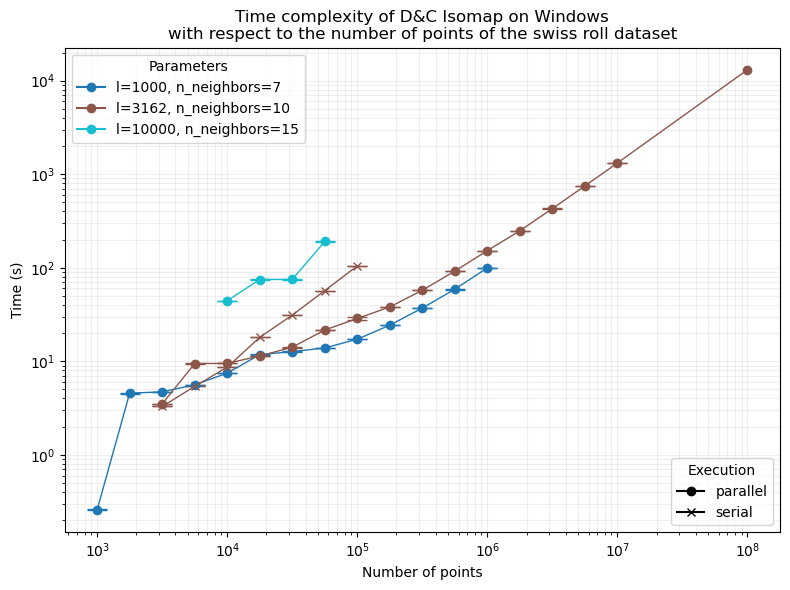

In [74]:
# Create plot
plt.figure(figsize=(8, 6))

# Get unique combinations of (l, n_neighbors) that exist in the data
unique_ln_combinations = grouped_results[[
    'l', 'n_neighbors']].drop_duplicates()

# Create a color mapping for each unique (l, n_neighbors) combination
cmap = {}
viridis = plt.get_cmap('tab10', len(unique_ln_combinations))
for i, (_, row) in enumerate(unique_ln_combinations.iterrows()):
    cmap[(row['l'], row['n_neighbors'])] = viridis(i)

# Define markers based on parallel value
markers = {0: 'x', 1: 'o'}

# Get all unique combinations including parallel
all_combinations = grouped_results[[
    'l', 'n_neighbors', 'parallel']].drop_duplicates()

# Create a plot for each (l, n_neighbors, parallel) combination
for _, row in all_combinations.iterrows():
    l = row['l']
    n_neighbors = row['n_neighbors']
    is_parallel = row['parallel']

    # Get the color based on (l, n_neighbors)
    color = cmap[(l, n_neighbors)]

    # Get data subset
    subset = grouped_results[(grouped_results['l'] == l) &
                             (grouped_results['n_neighbors'] == n_neighbors) &
                             (grouped_results['parallel'] == is_parallel)]

    plt.errorbar(subset['n'], subset['mean_time'], yerr=subset['std_error'],
                 marker=markers[is_parallel], markersize=6, linestyle='-', linewidth=1, color=color, ecolor=color, elinewidth=1, capsize=7)

# Set log scales for both axes
plt.xscale('log')
plt.yscale('log')

# Add plot details
plt.xlabel('Number of points')
plt.ylabel('Time (s)')
plt.title('Time complexity of D&C Isomap on Windows\nwith respect to the number of points of the swiss roll dataset')
plt.grid(True, which="both", ls="-", alpha=0.2)

# Create custom legend handles for (l, n_neighbors) pairs
lneighbors_handles = []
for _, row in unique_ln_combinations.iterrows():
    l = row['l']
    n_neighbors = row['n_neighbors']
    color = cmap[(l, n_neighbors)]
    handle = mlines.Line2D([], [], color=color, marker='o', linestyle='-',
                           markersize=6, label=f'l={l}, n_neighbors={n_neighbors}')
    lneighbors_handles.append(handle)

# Create custom legend handles for parallelization
parallel_handles = [
    mlines.Line2D([], [], color='k', marker='o', linestyle='-',
                  markersize=6, label='parallel'),
    mlines.Line2D([], [], color='k', marker='x', linestyle='-',
                  markersize=6, label='serial')
]

# Add both legends
plt.legend(handles=lneighbors_handles, loc='upper left')
plt.legend(handles=parallel_handles, loc='upper right')

first_legend = plt.legend(
    handles=lneighbors_handles, loc='upper left', title='Parameters')
plt.gca().add_artist(first_legend)
plt.legend(handles=parallel_handles, loc='lower right', title='Execution')

plt.tight_layout()
plt.show()